# Cointegration Testing:
1. Retrieves data from yahoo finance API
2. Uses yahooquery's Screener() class to request assets from yfinance related to a specific industry

In [1]:
import yfinance as yf
from yahooquery import Screener
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint, adfuller
import numpy as np
import itertools
import math

In [2]:
# The below instantiates an instance of the Screener class and returns all available screeners.
# For testing sake, the first 10 screeners returned are of interest
# Can specify filters for the screener by passing in ['most_actives','day_gainers', *count] as a parameter to 
# s.get_screeners(['most_actives', 'day_gainers'], 5) which returns a dictionary/JSON
NUMBER_ASSETS_TO_DOWNLOAD = 100
screener = Screener()
industries = screener.available_screeners
print("Number of industries returned by screener: ",len(industries))
selection = industries

industry = 'utilities_independent_power_producers'
bearish_stocks_now = selection[selection.index(industry)]
# returns assets in the bearish_stocks_now industry
bearish_info = screener.get_screeners(bearish_stocks_now, count=NUMBER_ASSETS_TO_DOWNLOAD)
bearish_assets = bearish_info[industry]['quotes']
symbols = []
for asset in bearish_assets:
    symbols.append(asset['symbol'])
# Symbols now contains all the 'tickers' of the assets we selected by industry, bearish_stocks_now
selection

Number of industries returned by screener:  383


['advertising_agencies',
 'aerospace_defense',
 'aggressive_small_caps',
 'agricultural_inputs',
 'airlines',
 'airports_air_services',
 'all_cryptocurrencies_au',
 'all_cryptocurrencies_ca',
 'all_cryptocurrencies_eu',
 'all_cryptocurrencies_gb',
 'all_cryptocurrencies_in',
 'all_cryptocurrencies_us',
 'aluminum',
 'analyst_strong_buy_stocks',
 'apparel_manufacturing',
 'apparel_retail',
 'asset_management',
 'auto_manufacturers',
 'auto_parts',
 'auto_truck_dealerships',
 'banks_diversified',
 'banks_regional',
 'bearish_stocks_right_now',
 'best_hist_performance_etfs',
 'best_hist_performance_etfs_asia',
 'best_hist_performance_etfs_europe',
 'best_hist_performance_mutual_funds',
 'best_hist_performance_mutual_funds_asia',
 'best_hist_performance_mutual_funds_europe',
 'beverages_brewers',
 'beverages_non_alcoholic',
 'beverages_wineries_distilleries',
 'biotechnology',
 'bond_etfs',
 'bond_mutual_funds',
 'bond_mutual_funds_asia',
 'bond_mutual_funds_europe',
 'broadcasting',
 'bui

### Other useful functions from yahooquery API, functionality is self explanatory:
1. import yahooquery as yq
   data = yq.get_currencies()

2. yq.get_market_summary(country='hong kong')
3. data = yq.search(ticker), other optional parameters = [query,quotes_count,news_count,first_quote,country]

Information source: https://yahooquery.dpguthrie.com/guide/misc/

In [3]:
# The following extracts data for the assets selected in industries array, and requests it's
# historic data from the yfinance API (Which has more functionality per asset that just offering historic data)

# Dictionary storing data, in the form of a pandas DataFrame, for every asset in 'symbols' array
NUMBER_ASSETS_TO_USE = 10
industry_data_dict = {}

def retrieveData(asset: str, period: str):
    data = yf.Ticker(asset)
    return data.history(period=period)

#Choosing the first 10 to prevent rate limiting while testing
# Making the period "1mo" while testing, can request "10y" and "max"
for asset in symbols[:NUMBER_ASSETS_TO_USE]:
    industry_data_dict[asset] = retrieveData(asset,"1y")

# A potentially much better way of downloading the data is:
# data = yf.download(symbols, start_date, end_date)['Adj Close']
# Which returns a neat dataframe where the columns are the assets and rows the historic 
industry_data_dict

{'VST':                                  Open        High         Low       Close  \
 Date                                                                        
 2023-11-09 00:00:00-05:00   34.175532   34.550221   34.037489   34.076931   
 2023-11-10 00:00:00-05:00   34.372744   34.619250   33.938892   33.998055   
 2023-11-13 00:00:00-05:00   33.998050   34.155814   33.756476   33.919170   
 2023-11-14 00:00:00-05:00   34.412180   34.806587   34.367807   34.727707   
 2023-11-15 00:00:00-05:00   34.579804   34.806589   34.165677   34.214977   
 ...                               ...         ...         ...         ...   
 2024-11-04 00:00:00-05:00  117.690002  118.800003  111.500000  115.739998   
 2024-11-05 00:00:00-05:00  116.309998  122.269997  115.889999  121.900002   
 2024-11-06 00:00:00-05:00  125.169998  127.000000  121.070000  126.089996   
 2024-11-07 00:00:00-05:00  138.110001  143.789993  130.020004  135.729996   
 2024-11-08 00:00:00-05:00  135.240005  144.770004  135.2

In [4]:
# function for retrieving timestamps of data in desired format for plotting

def get_timestamps(symbol:str):
    return list(map(lambda x: x.split(' ')[0] ,industry_data_dict[symbol].index.strftime('%Y-%m-%d %H:%M:%S').tolist()))

# get_timestamps('BTC-USD')

Some of the below code has been adapted from:
https://medium.com/@TejasEkawade/time-series-cointegration-retail-and-finance-applications-with-python-implementation-2f3511200aa3

In [5]:
# Function to plot graphs of co-integrated stocks for visualisation reasons:
# assets = ['BTC-USD','ETH-USD']
# start_date = '2021-10-01'
# end_date = '2023-10-01'

# below function takes in a dict of two items with ticker symbol as key and value an array of the data

def plotGraph(assets: dict, data=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
    # Access the first key and value for the first subplot
    axes[0].plot(list(assets.values())[0])
    axes[0].set_title(list(assets.keys())[0])
    axes[0].tick_params('x', labelrotation=45)
    
    # Access the second key and value for the second subplot
    axes[1].plot(list(assets.values())[1])
    axes[1].set_title(list(assets.keys())[1])
    axes[1].tick_params('x', labelrotation=45)
    
    plt.show()




Now for the co-integration testing of stock A, Stock B pairs

Out of 15 combinations of pairs, 1 cointegrated pairs were found.


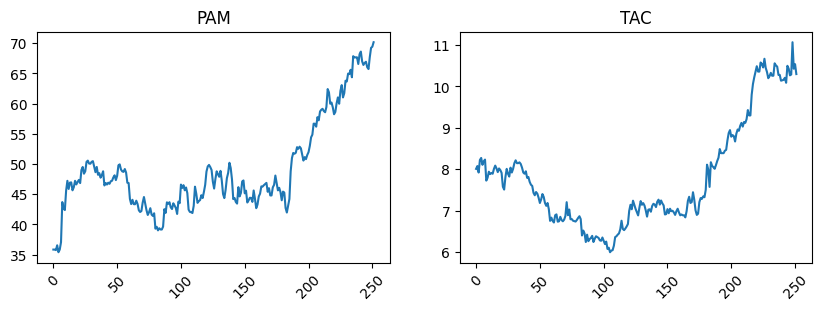

In [6]:
possible_pairs_assets = itertools.combinations(industry_data_dict.keys(),2)
cointegrated_stocks = []

for (stock_A,stock_B) in possible_pairs_assets:
    x = list(industry_data_dict[stock_A]['Close'])
    y = list(industry_data_dict[stock_B]['Close'])
    t_statistic, p_val, critical_p_val = coint(x,y)
    # print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%] critical_p_val')
    if p_val < 0.05 and t_statistic < critical_p_val[1]: # critical_p_value is an array of 3 relating to 1% 5% 10% critical values for the hypothesis test
        cointegrated_stocks.append((stock_A,stock_B))
number_cointegrated_stocks = len(cointegrated_stocks)
number_possible_combinations = math.comb(len(industry_data_dict.keys()),2)
print(f"Out of {number_possible_combinations} combinations of pairs, {number_cointegrated_stocks} cointegrated pairs were found.")

# pair = cointegrated_stocks[1]
# coint_single_dict = {pair[0]: list(industry_data_dict[pair[0]]['Close']),
#                      pair[1]: list(industry_data_dict[pair[1]]['Close'])}
# plotGraph(coint_single_dict)

for pairs in cointegrated_stocks:
    pair = cointegrated_stocks[cointegrated_stocks.index(pairs)]
    coint_single_dict = {pair[0]: list(industry_data_dict[pair[0]]['Close']),
                     pair[1]: list(industry_data_dict[pair[1]]['Close'])}
    plotGraph(coint_single_dict)

In [7]:
%store cointegrated_stocks industry_data_dict 

Stored 'cointegrated_stocks' (list)
Stored 'industry_data_dict' (dict)
